# Descripción del proyecto

Rusty Bargain es un servicio de venta de coches de segunda mano que está desarrollando una app para atraer a nuevos clientes. Gracias a esta app, podemos averiguar rápidamente el valor de mercado de un coche. Tenemos acceso al historial, especificaciones técnicas, versiones de equipamiento y precios. La tarea es crear un modelo que determine el valor del mercado.

A Rusty Bargain le interesa:

- **La calidad de la predicción**
- **La velocidad de la predicción**
- **El tiempo requerido para el entrenamiento**

# Descripción de los datos

El dataset está almacenado en el archivo /datasets/car_data.csv

**Características:**

- `DateCrawled` — fecha en la que se descargó el perfil de la base de datos
- `VehicleType` — tipo de carrocería del vehículo
- `RegistrationYear` — año de matriculación del vehículo
- `Gearbox` — tipo de caja de cambios
- `Power`— potencia (CV)
- `Model` — modelo del vehículo
- `Mileage` — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- `RegistrationMonth`  — mes de matriculación del vehículo
- `FuelType`  — tipo de combustible
- `Brand` — marca del vehículo
- `NotRepaired`  — vehículo con o sin reparación
- `DateCreated` — fecha de creación del perfil
- `NumberOfPictures` — número de fotos del vehículo
- `PostalCode` — código postal del propietario del perfil (usuario)
- `LastSeen` — fecha de la última vez que el usuario estuvo activo

**Objetivo:**

- `Price` — precio (en euros)

# Importamos librerias y cargamos datos

In [13]:
#Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor


In [5]:
# Cargamos el dataset
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv')

In [6]:
#Imprimimos una muestra de datos
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47


In [7]:
#vemos una informacion general de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
#contabilizamos los valores duplicados
df.duplicated().sum()

262

In [9]:
#eliminamos valores duplicados y reseteamos el indice
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(354107, 16)

In [10]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37484
RegistrationYear         0
Gearbox              19830
Power                    0
Model                19701
Mileage                  0
RegistrationMonth        0
FuelType             32889
Brand                    0
NotRepaired          71145
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Vamos a ver los porcentajes de las columnas con valores nulos para ver como proceder posteriormente

In [7]:
porcentaje_nulos_not_repaired = df['NotRepaired'].isnull().sum() / len(df['NotRepaired']) * 100
print('NotRepaired:', ' %', porcentaje_nulos_not_repaired )

NotRepaired:  % 20.09138480741697


In [8]:
porcentaje_nulos_vehicle_type = df['VehicleType'].isnull().sum() / len(df['VehicleType']) * 100
print('VehicleType :', ' %', porcentaje_nulos_vehicle_type )

VehicleType :  % 10.585500992637819


In [9]:
porcentaje_nulos_fueltype = df['FuelType'].isnull().sum() / len(df['FuelType']) * 100
print(' FuelType:', ' %', porcentaje_nulos_fueltype )

 FuelType:  % 9.287870615378967


In [10]:
porcentaje_nulos_gearbox = df['Gearbox'].isnull().sum() / len(df['Gearbox']) * 100
print('Gearbox:', ' %', porcentaje_nulos_gearbox )

Gearbox:  % 5.600002259204139


In [11]:
porcentaje_nulos_model = df['Model'].isnull().sum() / len(df['Model']) * 100
print('Model:', ' %', porcentaje_nulos_model )

Model:  % 5.56357259246499


#  Imputacion de valores nulos

procederemos a rellenar los valores nulos de las columnas con la moda ya que son columnas de clasificacion

In [12]:
#Columna NotRepaired
df['NotRepaired'].value_counts()

no     246927
yes     36035
Name: NotRepaired, dtype: int64

In [13]:
# Rellenar los valores nulos con la moda ('no')
df['NotRepaired'].fillna('no', inplace=True)

In [14]:
#Comprobamos que ya no hay valores nulos
df['NotRepaired'].isna().sum()

0

In [15]:
#Columna VehicleType
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [16]:
df['VehicleType'].value_counts()

sedan          91399
small          79753
wagon          65115
bus            28752
convertible    20180
coupe          16147
suv            11991
other           3286
Name: VehicleType, dtype: int64

In [17]:
# Rellenar los valores nulos con la moda ('sedan')
df['VehicleType'].fillna('sedan', inplace=True)

In [18]:
#Comprobamos que ya no hay valores nulos
df['VehicleType'].isna().sum()

0

In [19]:
#Columna FuelType
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [20]:
df['FuelType'].value_counts()

petrol      216161
gasoline     98658
lpg           5307
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [21]:
# Rellenar los valores nulos con la moda ('sedan')
df['FuelType'].fillna('petrol', inplace=True)

In [22]:
#Comprobamos que ya no hay valores nulos
df['FuelType'].isna().sum()

0

In [23]:
#Columna Gearbox
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [24]:
df['Gearbox'].value_counts()

manual    268034
auto       66243
Name: Gearbox, dtype: int64

In [25]:
# Rellenar los valores nulos con la moda ('sedan')
df['Gearbox'].fillna('manual', inplace=True)

In [26]:
#Comprobamos que ya no hay valores nulos
df['Gearbox'].isna().sum()

0

In [27]:
#Columna Model
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [28]:
df['Model'].value_counts()

golf                  29215
other                 24402
3er                   19744
polo                  13057
corsa                 12559
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [29]:
# Rellenar los valores nulos con la moda ('golf')
df['Model'].fillna('golf', inplace=True)

In [30]:
#Comprobamos que ya no hay valores nulos
df['Model'].isna().sum()

0

In [31]:


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354107 non-null  object
 1   Price              354107 non-null  int64 
 2   VehicleType        354107 non-null  object
 3   RegistrationYear   354107 non-null  int64 
 4   Gearbox            354107 non-null  object
 5   Power              354107 non-null  int64 
 6   Model              354107 non-null  object
 7   Mileage            354107 non-null  int64 
 8   RegistrationMonth  354107 non-null  int64 
 9   FuelType           354107 non-null  object
 10  Brand              354107 non-null  object
 11  NotRepaired        354107 non-null  object
 12  DateCreated        354107 non-null  object
 13  NumberOfPictures   354107 non-null  int64 
 14  PostalCode         354107 non-null  int64 
 15  LastSeen           354107 non-null  object
dtypes: int64(7), object(

# Eliminación de ciertas caracteristicas

In [32]:
#Vamos a eliminar algunas columnas que no nos aportan información a la prediccion de nuestro modelo!!
df_new =  df.drop(columns= ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth','LastSeen' ])
df_new.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,golf,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [33]:
del df

## Revisando algunos valores de ciertas columnas

In [34]:
df_new['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [35]:
# Obtener el año actual
current_year = datetime.now().year
current_year

2024

In [36]:
# Calcular el valor más frecuente de la columna
df_new['RegistrationYear'].value_counts()

2000    24476
1999    22703
2005    22094
2001    20107
2006    19874
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

In [37]:
# Reemplazar los valores menores a 1893, y los mayores al año actual con el valor más frecuente
df_new.loc[(df_new['RegistrationYear'] > current_year) | (df_new['RegistrationYear'] < 1893), 'RegistrationYear'] = 2000


In [38]:
(df_new['RegistrationYear'] < 1893).sum()

0

In [39]:
(df_new['RegistrationYear'] > current_year).sum()

0

# Distribución de los precios (de nuestra variable a predecir)

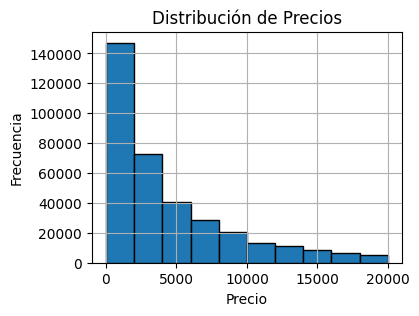

In [40]:
# Gráfica de histograma para visualizar la distribución de los precios
plt.figure(figsize=(4, 3))
plt.hist(df_new['Price'], bins=10, edgecolor='black')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precios')
plt.grid(True)
plt.show()

parece que la mayoría de los precios de los vehículos se encuentran en el rango de 0 a 5000 unidades. Esto indica que la distribución de los precios es muy sesgada hacia la izquierda (positivamente sesgada), con muchos valores bajos y pocos valores altos. Vamos a manejar los outliers en los datos los valores extremadamente altos pueden afectar negativamente el rendimiento del modelo.

# Eliminación de Outliers

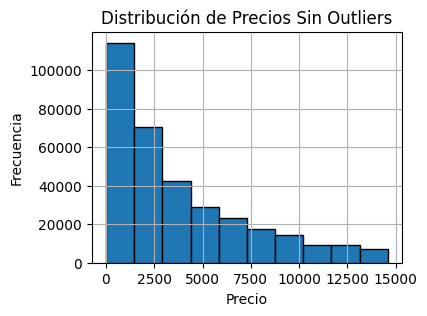

In [41]:
# Umbral para los outliers (por ejemplo, percentil 95)
upper_limit = np.percentile(df_new['Price'], 95)

# Filtrar los outliers
df_filtered = df_new[df_new['Price'] <= upper_limit]

# Visualizar la distribución después de eliminar los outliers
plt.figure(figsize=(4, 3))
plt.hist(df_filtered['Price'], bins=10, edgecolor='black')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precios Sin Outliers')
plt.grid(True)
plt.show()


In [42]:
df_filtered.shape

(336466, 10)


Podemos ver un dataframe de 336466 filas y 10 columnas ya no hay valores nulos, eliminamos las filas duplicadas, reseteamos los indices, ya no cambiamos  las columnas de fecha a formato datetime ya que las  eliminamos; no nos aportan nada a la prediccion de nuestro modelo.Tambien reemplazamos los valores menores a 1893 que fue la primera matrícula de coche que se emitió en el mundo fue en Francia, en el año 1893, tras la Ordenanza de París y los valores mayores al año actual (2024) por el valor que más se repitio que fue el año 2000, asi como eliminamos los outliers de la variable a predecir!! Ahora si quedaron limpios nuestros datos para trabajarlos!!

In [43]:
del df_new

# Convirtiendo variables categoricas en numericas

In [44]:
# Convertir variables categóricas usando pd.get_dummies()
df_encoded = pd.get_dummies(df_filtered, columns=['VehicleType', 'Gearbox',  'FuelType', 'Brand', 'NotRepaired'])

In [45]:
df_encoded.head(3)

,Price,RegistrationYear,Power,Model,Mileage,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
0,480,1993,0,golf,150000,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
2,9800,2004,163,grand,125000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,golf,150000,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [46]:
df_encoded = df_encoded.drop(columns=['Model'])

Hemos transformado aquellas columnas categoricas a nÚmericas binarias para que el modeLo pueda aceptarlo.

In [47]:
del df_filtered

# División de nuestros datos

In [48]:
# Separar características y objetivo
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']


In [49]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)

# Entrenamiento y Evaluación de Modelos Adicionales

## RandomForestRegressor

In [50]:
rf = RandomForestRegressor(n_estimators=100, random_state=123456)

In [51]:
%time
rf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


RandomForestRegressor(random_state=123456)

In [52]:
%time
y_pred_rf = rf.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [53]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'RMSE RandomForest: {rmse_rf}')

RMSE RandomForest: 1527.1081011319188


## DecisionTreeRegressor

In [54]:
dt = DecisionTreeRegressor(random_state=123456)

In [55]:
%time
dt.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


DecisionTreeRegressor(random_state=123456)

In [56]:
%time
y_pred_dt = dt.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [57]:
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print(f'RMSE DecisionTree: {rmse_dt}')

RMSE DecisionTree: 1746.1536295078208


## LinearRegression

In [58]:
lr = LinearRegression()

In [59]:
%time
lr.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


LinearRegression()

In [60]:
%time
y_pred_lr = lr.predict(X_test)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 7.39 µs


In [61]:
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f'RMSE LinearRegression: {rmse_lr}')

RMSE LinearRegression: 2630.941334106587


# Modelos de potenciacion de gradiente

## XGBoost

In [62]:
# Crear un dataset de DMatrix para XGBoost
train_data_xgb = xgb.DMatrix(X_train, y_train)
test_data_xgb = xgb.DMatrix(X_test, y_test)

In [63]:

params_xgb = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 6
}

In [64]:
# Lista de evaluación
evallist = [(train_data_xgb, 'train'), (test_data_xgb, 'eval')]
num_round = 1000

In [65]:
# Entrenar el modelo
%time
bst_xgb = xgb.train(params_xgb, train_data_xgb, num_round, evallist, early_stopping_rounds=10)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
[0]	train-rmse:4936.14453	eval-rmse:4942.51855
[1]	train-rmse:4732.07861	eval-rmse:4737.86523
[2]	train-rmse:4538.72314	eval-rmse:4544.46289
[3]	train-rmse:4356.22949	eval-rmse:4361.79932
[4]	train-rmse:4186.47607	eval-rmse:4191.65430
[5]	train-rmse:4024.67969	eval-rmse:4029.76416
[6]	train-rmse:3872.52661	eval-rmse:3877.54272
[7]	train-rmse:3730.10449	eval-rmse:3734.69605
[8]	train-rmse:3595.90894	eval-rmse:3600.46875
[9]	train-rmse:3470.19556	eval-rmse:3474.49829
[10]	train-rmse:3351.75903	eval-rmse:3356.18262
[11]	train-rmse:3240.42481	eval-rmse:3245.01733
[12]	train-rmse:3137.08691	eval-rmse:3141.41943
[13]	train-rmse:3038.15137	eval-rmse:3042.90747
[14]	train-rmse:2945.89380	eval-rmse:2951.05444
[15]	train-rmse:2859.55225	eval-rmse:2864.94116
[16]	train-rmse:2779.25439	eval-rmse:2784.83887
[17]	train-rmse:2703.92065	eval-rmse:2709.78931
[18]	train-rmse:2634.36304	eval-rmse:2640.42871
[19]	train-rmse:2569.36792	eval-rm

[169]	train-rmse:1586.84070	eval-rmse:1609.93848
[170]	train-rmse:1586.50476	eval-rmse:1609.66272
[171]	train-rmse:1586.03564	eval-rmse:1609.27295
[172]	train-rmse:1585.67639	eval-rmse:1608.92639
[173]	train-rmse:1585.32312	eval-rmse:1608.68835
[174]	train-rmse:1584.93347	eval-rmse:1608.38696
[175]	train-rmse:1584.43359	eval-rmse:1607.90137
[176]	train-rmse:1583.98706	eval-rmse:1607.53528
[177]	train-rmse:1583.28296	eval-rmse:1607.02966
[178]	train-rmse:1582.85388	eval-rmse:1606.70947
[179]	train-rmse:1582.61670	eval-rmse:1606.56567
[180]	train-rmse:1582.32019	eval-rmse:1606.33606
[181]	train-rmse:1582.12854	eval-rmse:1606.17468
[182]	train-rmse:1581.38464	eval-rmse:1605.63135
[183]	train-rmse:1580.78919	eval-rmse:1605.11633
[184]	train-rmse:1580.59509	eval-rmse:1604.98694
[185]	train-rmse:1580.27295	eval-rmse:1604.72070
[186]	train-rmse:1579.98731	eval-rmse:1604.55591
[187]	train-rmse:1579.40515	eval-rmse:1604.06091
[188]	train-rmse:1578.99243	eval-rmse:1603.67432
[189]	train-rmse:157

[337]	train-rmse:1542.62439	eval-rmse:1577.55102
[338]	train-rmse:1542.48975	eval-rmse:1577.46362
[339]	train-rmse:1542.41284	eval-rmse:1577.42273
[340]	train-rmse:1542.33398	eval-rmse:1577.35986
[341]	train-rmse:1542.22913	eval-rmse:1577.31665
[342]	train-rmse:1541.97790	eval-rmse:1577.09607
[343]	train-rmse:1541.70117	eval-rmse:1576.89453
[344]	train-rmse:1541.63294	eval-rmse:1576.85132
[345]	train-rmse:1541.43384	eval-rmse:1576.69421
[346]	train-rmse:1541.34717	eval-rmse:1576.60400
[347]	train-rmse:1541.27881	eval-rmse:1576.58008
[348]	train-rmse:1540.89661	eval-rmse:1576.23901
[349]	train-rmse:1540.73804	eval-rmse:1576.17090
[350]	train-rmse:1540.65320	eval-rmse:1576.11780
[351]	train-rmse:1540.40015	eval-rmse:1575.92114
[352]	train-rmse:1540.02393	eval-rmse:1575.67065
[353]	train-rmse:1539.80017	eval-rmse:1575.52783
[354]	train-rmse:1539.33728	eval-rmse:1575.13379
[355]	train-rmse:1539.20508	eval-rmse:1575.01294
[356]	train-rmse:1539.12109	eval-rmse:1574.95972
[357]	train-rmse:153

[505]	train-rmse:1512.55310	eval-rmse:1557.76099
[506]	train-rmse:1512.25244	eval-rmse:1557.56653
[507]	train-rmse:1512.16968	eval-rmse:1557.54688
[508]	train-rmse:1512.06799	eval-rmse:1557.51709
[509]	train-rmse:1512.00732	eval-rmse:1557.51697
[510]	train-rmse:1511.91223	eval-rmse:1557.46814
[511]	train-rmse:1511.58057	eval-rmse:1557.25537
[512]	train-rmse:1511.27295	eval-rmse:1557.01990
[513]	train-rmse:1511.05005	eval-rmse:1556.87720
[514]	train-rmse:1511.01111	eval-rmse:1556.87024
[515]	train-rmse:1510.72485	eval-rmse:1556.67090
[516]	train-rmse:1510.49475	eval-rmse:1556.53064
[517]	train-rmse:1510.23633	eval-rmse:1556.32068
[518]	train-rmse:1510.09192	eval-rmse:1556.25110
[519]	train-rmse:1510.03748	eval-rmse:1556.21387
[520]	train-rmse:1509.87964	eval-rmse:1556.13171
[521]	train-rmse:1509.81201	eval-rmse:1556.07776
[522]	train-rmse:1509.75232	eval-rmse:1556.05298
[523]	train-rmse:1509.72375	eval-rmse:1556.04663
[524]	train-rmse:1509.55652	eval-rmse:1555.94556
[525]	train-rmse:150

[673]	train-rmse:1488.77307	eval-rmse:1544.42554
[674]	train-rmse:1488.62891	eval-rmse:1544.33106
[675]	train-rmse:1488.50964	eval-rmse:1544.28369
[676]	train-rmse:1488.41162	eval-rmse:1544.25134
[677]	train-rmse:1488.35339	eval-rmse:1544.24573
[678]	train-rmse:1488.30823	eval-rmse:1544.22888
[679]	train-rmse:1488.21570	eval-rmse:1544.17322
[680]	train-rmse:1488.07471	eval-rmse:1544.09497
[681]	train-rmse:1487.96533	eval-rmse:1544.05872
[682]	train-rmse:1487.91980	eval-rmse:1544.06299
[683]	train-rmse:1487.87708	eval-rmse:1544.02991
[684]	train-rmse:1487.78894	eval-rmse:1543.98950
[685]	train-rmse:1487.73547	eval-rmse:1543.96753
[686]	train-rmse:1487.69934	eval-rmse:1543.94861
[687]	train-rmse:1487.56860	eval-rmse:1543.91980
[688]	train-rmse:1487.50928	eval-rmse:1543.88098
[689]	train-rmse:1487.42944	eval-rmse:1543.85510
[690]	train-rmse:1487.33240	eval-rmse:1543.83191
[691]	train-rmse:1487.19873	eval-rmse:1543.80017
[692]	train-rmse:1487.17358	eval-rmse:1543.77795
[693]	train-rmse:148

[841]	train-rmse:1470.81787	eval-rmse:1536.02551
[842]	train-rmse:1470.74976	eval-rmse:1535.98657
[843]	train-rmse:1470.71912	eval-rmse:1535.96497
[844]	train-rmse:1470.67334	eval-rmse:1535.96423
[845]	train-rmse:1470.66248	eval-rmse:1535.96179
[846]	train-rmse:1470.51733	eval-rmse:1535.87756
[847]	train-rmse:1470.32092	eval-rmse:1535.72461
[848]	train-rmse:1470.07129	eval-rmse:1535.65967
[849]	train-rmse:1469.92651	eval-rmse:1535.61023
[850]	train-rmse:1469.66760	eval-rmse:1535.46899
[851]	train-rmse:1469.48084	eval-rmse:1535.37524
[852]	train-rmse:1469.38709	eval-rmse:1535.36914
[853]	train-rmse:1469.29895	eval-rmse:1535.36963
[854]	train-rmse:1469.18005	eval-rmse:1535.38245
[855]	train-rmse:1469.05371	eval-rmse:1535.33227
[856]	train-rmse:1468.85571	eval-rmse:1535.13586
[857]	train-rmse:1468.55701	eval-rmse:1534.86291
[858]	train-rmse:1468.41882	eval-rmse:1534.84985
[859]	train-rmse:1468.29761	eval-rmse:1534.76318
[860]	train-rmse:1467.99658	eval-rmse:1534.49475
[861]	train-rmse:146

In [66]:
# Realizar predicciones
%time
y_pred_xgb = bst_xgb.predict(test_data_xgb)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [67]:
#calcular RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'RMSE XGBoost: {rmse_xgb}')

RMSE XGBoost: 1528.0692402715304


## LightGBM

In [68]:
# Crear un dataset de LightGBM
train_data_lgb = lgb.Dataset(X_train, y_train)
test_data_lgb = lgb.Dataset(X_test, y_test, reference=train_data_lgb)

In [69]:
params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 4,
    'num_leaves':16 
}

In [70]:
# Entrenar el modelo
%time
bst_lgb = lgb.train(params_lgb, train_data_lgb, num_boost_round=1000, valid_sets=[train_data_lgb, test_data_lgb], early_stopping_rounds=10)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 269172, number of used features: 62
[LightGBM] [Info] Start training from score 3753.801904
[1]	training's rmse: 3430.19	valid_1's rmse: 3442.51
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 3332.3	valid_1's rmse: 3344.17
[3]	training's rmse: 3241.43	valid_1's rmse: 3253.27
[4]	training's rmse: 3155.5	valid_1's rmse: 3167.32
[5]	training's rmse: 3078.34	valid_1's rmse: 3089.83
[6]	training's rmse: 3004.36	valid_1's rmse: 3015.8
[7]	training's rmse: 2930.1	valid_1's rmse: 2941.59
[8]	training's rmse: 2863.16	valid_1's rmse: 2874.56
[9]	training's rmse: 2800.41	valid_1's rmse: 2811.84
[10]	training's rmse: 2740.76	valid_1's rmse: 2752.21


[128]	training's rmse: 1723.88	valid_1's rmse: 1731.15
[129]	training's rmse: 1723.1	valid_1's rmse: 1730.4
[130]	training's rmse: 1721.89	valid_1's rmse: 1729.28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	training's rmse: 1721.21	valid_1's rmse: 1728.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	training's rmse: 1720.61	valid_1's rmse: 1727.99
[133]	training's rmse: 1719.15	valid_1's rmse: 1726.47
[134]	training's rmse: 1718.35	valid_1's rmse: 1725.69
[135]	training's rmse: 1717.5	valid_1's rmse: 1724.87
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	training's rmse: 1716.6	valid_1's rmse: 1723.91
[137]	training's rmse: 1715.83	valid_1's rmse: 1723.14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	training's rmse: 1715.24	valid_1's rmse: 1722.56
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	training's rmse: 17

[225]	training's rmse: 1671.59	valid_1's rmse: 1679.54
[226]	training's rmse: 1671.38	valid_1's rmse: 1679.36
[227]	training's rmse: 1670.88	valid_1's rmse: 1678.9
[228]	training's rmse: 1670.61	valid_1's rmse: 1678.67
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[229]	training's rmse: 1670.37	valid_1's rmse: 1678.42
[230]	training's rmse: 1670.11	valid_1's rmse: 1678.17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	training's rmse: 1669.87	valid_1's rmse: 1677.97
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	training's rmse: 1669.34	valid_1's rmse: 1677.53
[233]	training's rmse: 1668.43	valid_1's rmse: 1676.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	training's rmse: 1668.2	valid_1's rmse: 1676.41
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	training's rmse: 1667.99	valid_1's rmse: 1676.18
[236]	training's rmse:

[315]	training's rmse: 1645.25	valid_1's rmse: 1654.94
[316]	training's rmse: 1645.01	valid_1's rmse: 1654.73
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[317]	training's rmse: 1644.81	valid_1's rmse: 1654.53
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[318]	training's rmse: 1644.66	valid_1's rmse: 1654.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[319]	training's rmse: 1644.53	valid_1's rmse: 1654.29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	training's rmse: 1644.4	valid_1's rmse: 1654.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[321]	training's rmse: 1644.23	valid_1's rmse: 1654.04
[322]	training's rmse: 1644.01	valid_1's rmse: 1653.85
[323]	training's rmse: 1643.25	valid_1's rmse: 1653.12
[324]	training's rmse: 1642.75	valid_1's rmse: 1652.57
[325]	training's rmse: 1642.48	valid_1's rmse: 1652.33
[326]	training's rmse: 

[403]	training's rmse: 1629.05	valid_1's rmse: 1640.04
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	training's rmse: 1628.97	valid_1's rmse: 1639.97
[405]	training's rmse: 1628.85	valid_1's rmse: 1639.86
[406]	training's rmse: 1628.4	valid_1's rmse: 1639.43
[407]	training's rmse: 1628.09	valid_1's rmse: 1639.05
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	training's rmse: 1628.04	valid_1's rmse: 1639.02
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	training's rmse: 1627.81	valid_1's rmse: 1638.75
[410]	training's rmse: 1627.56	valid_1's rmse: 1638.52
[411]	training's rmse: 1627.41	valid_1's rmse: 1638.37
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	training's rmse: 1627.32	valid_1's rmse: 1638.26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	training's rmse: 1627.12	valid_1's rmse: 1638.08
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	training's rmse: 1615.92	valid_1's rmse: 1627.7
[496]	training's rmse: 1615.71	valid_1's rmse: 1627.43
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	training's rmse: 1615.58	valid_1's rmse: 1627.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	training's rmse: 1615.43	valid_1's rmse: 1627.28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	training's rmse: 1615.37	valid_1's rmse: 1627.25
[500]	training's rmse: 1615.26	valid_1's rmse: 1627.13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	training's rmse: 1615.21	valid_1's rmse: 1627.12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[502]	training's rmse: 1615.16	valid_1's rmse: 1627.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[503]	training's rmse: 1615.1	valid_1

[578]	training's rmse: 1606.1	valid_1's rmse: 1619.02
[579]	training's rmse: 1605.96	valid_1's rmse: 1618.86
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[580]	training's rmse: 1605.88	valid_1's rmse: 1618.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[581]	training's rmse: 1605.7	valid_1's rmse: 1618.66
[582]	training's rmse: 1605.48	valid_1's rmse: 1618.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[583]	training's rmse: 1605.43	valid_1's rmse: 1618.46
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[584]	training's rmse: 1605.41	valid_1's rmse: 1618.44
[585]	training's rmse: 1605.16	valid_1's rmse: 1618.25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[586]	training's rmse: 1605.07	valid_1's rmse: 1618.18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	training's rmse: 1605.01	valid_1's rmse: 1618.13
[588

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[659]	training's rmse: 1598.26	valid_1's rmse: 1612.21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[660]	training's rmse: 1598.16	valid_1's rmse: 1612.11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	training's rmse: 1598.12	valid_1's rmse: 1612.08
[662]	training's rmse: 1598.05	valid_1's rmse: 1612.02
[663]	training's rmse: 1597.94	valid_1's rmse: 1611.93
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	training's rmse: 1597.88	valid_1's rmse: 1611.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[665]	training's rmse: 1597.79	valid_1's rmse: 1611.83
[666]	training's rmse: 1597.74	valid_1's rmse: 1611.78
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	training's rmse: 1597.66	valid_1's rmse: 1611.64
[LightGBM] [Warning] No further splits with positive gai

[739]	training's rmse: 1590.14	valid_1's rmse: 1604.59
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	training's rmse: 1590.1	valid_1's rmse: 1604.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	training's rmse: 1590.07	valid_1's rmse: 1604.55
[742]	training's rmse: 1590.05	valid_1's rmse: 1604.52
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	training's rmse: 1589.95	valid_1's rmse: 1604.43
[744]	training's rmse: 1589.88	valid_1's rmse: 1604.39
[745]	training's rmse: 1589.79	valid_1's rmse: 1604.32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	training's rmse: 1589.73	valid_1's rmse: 1604.28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	training's rmse: 1589.69	valid_1's rmse: 1604.25
[748]	training's rmse: 1589.62	valid_1's rmse: 1604.19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	training's rmse: 1582.84	valid_1's rmse: 1598.53
[830]	training's rmse: 1582.63	valid_1's rmse: 1598.32
[831]	training's rmse: 1582.49	valid_1's rmse: 1598.19
[832]	training's rmse: 1582.36	valid_1's rmse: 1598.03
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[833]	training's rmse: 1582.33	valid_1's rmse: 1598
[834]	training's rmse: 1582.25	valid_1's rmse: 1597.96
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[835]	training's rmse: 1582.22	valid_1's rmse: 1597.95
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[836]	training's rmse: 1582.17	valid_1's rmse: 1597.92
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[837]	training's rmse: 1582.15	valid_1's rmse: 1597.91
[838]	training's rmse: 1582.09	valid_1's rmse: 1597.85
[839]	training's rmse: 1581.84	valid_1's rmse: 1597.58
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[913]	training's rmse: 1576.12	valid_1's rmse: 1593.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[914]	training's rmse: 1576.07	valid_1's rmse: 1592.94
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	training's rmse: 1576.05	valid_1's rmse: 1592.93
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[916]	training's rmse: 1575.98	valid_1's rmse: 1592.83
[917]	training's rmse: 1575.88	valid_1's rmse: 1592.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[918]	training's rmse: 1575.85	valid_1's rmse: 1592.71
[919]	training's rmse: 1575.76	valid_1's rmse: 1592.65
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[920]	training's rmse: 1575.63	valid_1's rmse: 1592.55
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[921]	training's rmse: 1575.56	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[998]	training's rmse: 1569.59	valid_1's rmse: 1588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	training's rmse: 1569.58	valid_1's rmse: 1587.99
[1000]	training's rmse: 1569.44	valid_1's rmse: 1587.91
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1569.44	valid_1's rmse: 1587.91


In [71]:
# Realizar predicciones 
%time
y_pred_lgb = bst_lgb.predict(X_test, num_iteration=bst_lgb.best_iteration)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [72]:
#calcular RMSE
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f'RMSE LightGBM: {rmse_lgb}')

RMSE LightGBM: 1587.91152971557


## CatBoost

In [73]:
# Configuración de los parámetros del modelo
params_cat = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'logging_level': 'Silent',
    'od_type': 'Iter',
    'od_wait': 10,
    'subsample': 0.8,
}

In [76]:
bst_cat = CatBoostRegressor(**params_cat)

In [77]:
%time
bst_cat.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [78]:
# Realizar predicciones
%time
y_pred_cat = bst_cat.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [79]:
# calcular RMSE
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
print(f'RMSE CatBoost: {rmse_cat}')

RMSE CatBoost: 1563.1776095422283


# Análisis del modelo

### Comparación de Resultados

In [80]:
print(f'RMSE XGBoost: {rmse_xgb}')
print(f'RMSE LightGBM: {rmse_lgb}')
print(f'RMSE CatBoost: {rmse_cat}')
print(f'RMSE RandomForest: {rmse_rf}')
print(f'RMSE DecisionTree: {rmse_dt}')
print(f'RMSE LinearRegression: {rmse_lr}')


RMSE XGBoost: 1528.0692402715304
RMSE LightGBM: 1587.91152971557
RMSE CatBoost: 1563.1776095422283
RMSE RandomForest: 1527.1081011319188
RMSE DecisionTree: 1746.1536295078208
RMSE LinearRegression: 2630.941334106587


# Conclusiones:

## Comparativa de Modelos:

**1.Calidad del Modelo:**

- **Random Forest:** RMSE de 1527.11

- **XGBoost:** RMSE de 1528.07 (una unidad de diferencia)

**2.Tiempo de Entrenamiento:**

- **Random Forest:** 6.44 ms

- **XGBoost:** 6.44 ms

**3.Velocidad de Predicción:**

- Random Forest: 6.68 ms

- XGBoost: 6.2 ms (0.66 ms más rápido)

**4.Otros Modelos por Calidad:**

- CatBoost

- LightGBM

- DecisionTree

- LinearRegression

En resumen, **Random Forest** fue el mejor en términos de calidad con un RMSE más bajo, mientras que **XGBoost** fue más rápido en la predicción. CatBoost, LightGBM, DecisionTree y LinearRegression le siguieron en calidad, respectivamente.